In [56]:
import os
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np

# Import relevant python packages
from gpet import utils, dataset, edgetrace
%matplotlib inline

In [57]:
reload(dataset)
reload(utils)

<module 'gpet.utils' from '/Users/uzaykaradag/Developer/ELM-GPR-Tracer/gpet/utils.py'>

# Loading the dataset for testing
Here the test subset of the dataset is imported to test the SegNet model's performance vs the Chain Model (SegNet + GPET)

In [58]:
# Set up directories
scan_dir = '/Users/uzaykaradag/Developer/ELM-GPR-Tracer/data/scans'
pred_mask_dir = '/Users/uzaykaradag/Developer/ELM-GPR-Tracer/data/pred'
gt_mask_dir = '/Users/uzaykaradag/Developer/ELM-GPR-Tracer/data/masks'

# Get the list of scan and mask filenames
scan_files = set(os.listdir(scan_dir))
pred_mask_files = set(os.listdir(pred_mask_dir))
gt_mask_files = set(os.listdir(gt_mask_dir))

# Get only the matching files across all three directories
matching_files = list(scan_files.intersection(pred_mask_files, gt_mask_files))

# Ensure we have matching files
if not matching_files:
    raise ValueError("No matching files found across scans, predicted masks, and ground truth masks!")

print(f'Test subset of size {len(matching_files)}.')

# Load the dataset
scans, pred_elm_coords, gt_elm_coords = dataset.load_dataset(matching_files, scan_dir, pred_mask_dir, gt_mask_dir)

print(f"Number of scans loaded: {len(scans)}")
print(f"Shape of first scan: {scans[0].shape}")
print(f"Number of predicted ELM coordinates for first scan: {len(pred_elm_coords[0])}")
print(f"Number of ground truth ELM coordinates for first scan: {len(gt_elm_coords[0])}")

Test subset of size 1048.
Number of scans loaded: 1048
Shape of first scan: (225, 730)
Number of predicted ELM coordinates for first scan: 2460
Number of ground truth ELM coordinates for first scan: 2232


In [59]:
# Test the function using a singular scan
test_idx = 500
test_scan = scans[test_idx]
segnet_elm = pred_elm_coords[test_idx]
gt_elm = gt_elm_coords[test_idx]

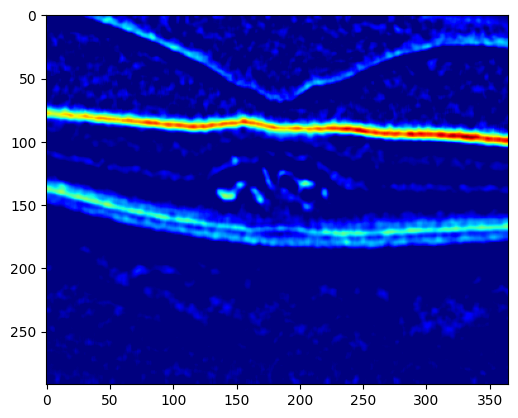

In [60]:
# Create a kernel for edge detection
kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)
# Compute the gradient image
test_edge_map = utils.comp_grad_img(test_scan, kernel)

plt.imshow(test_edge_map, cmap='jet')

In [61]:
print(f"Shape of test_scan: {test_scan.shape}")
print(f"Shape of pred_test: {segnet_elm.shape}")
print(f"Shape of gt_test: {gt_elm.shape}")

Shape of test_scan: (292, 365)
Shape of pred_test: (1222, 2)
Shape of gt_test: (1159, 2)


## Running GP Edge Tracing using only the initialisation points

In [62]:
# Get initialization edges from the pred_test aka mask
init = segnet_elm[[0, -1], :][:, [1, 0]]
init

array([[  0, 133],
       [364, 165]])

In [63]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True
)

elm_tracer = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

In [64]:
elm_pred, elm_ci = elm_tracer()

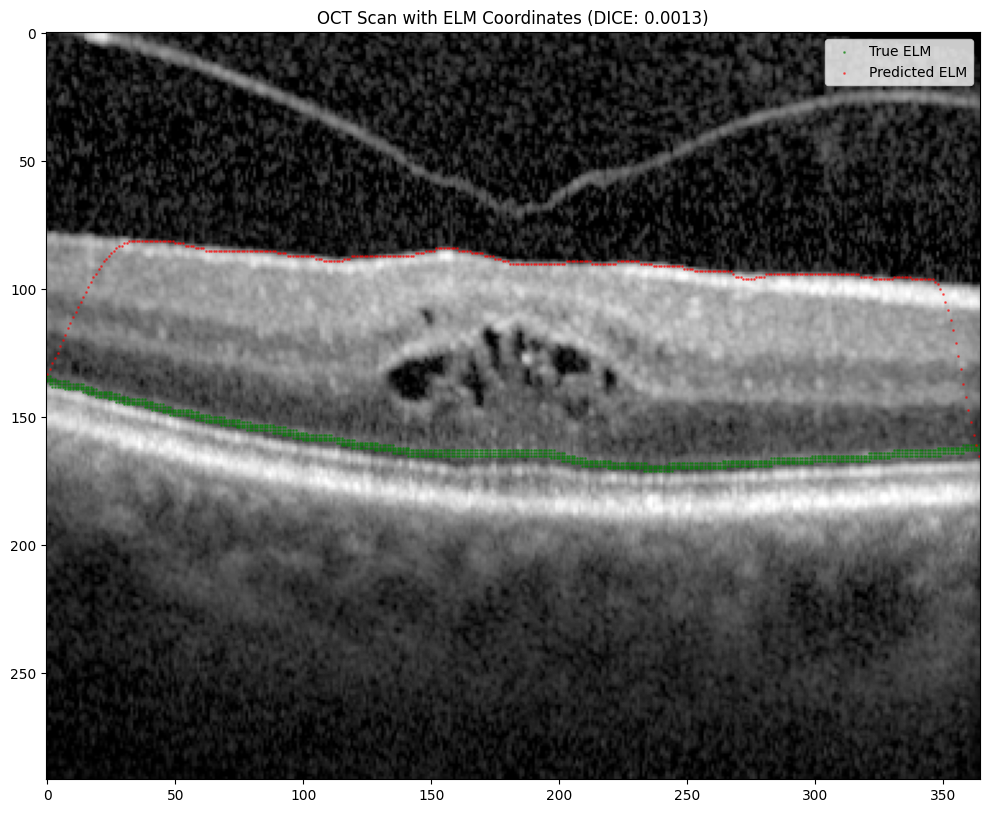

In [65]:
utils.plot_elm(test_scan, elm_pred, compare=True, true_elm_coords=gt_elm)

**The results are not great since the GPEdgeTracer focuses on the more distinct edge found at the top of the cross section. We will make use of the obs variable to guide the GPET algorithm to trace the ELM.** 

## Adding randomly selected observation points from the SegNet prediction

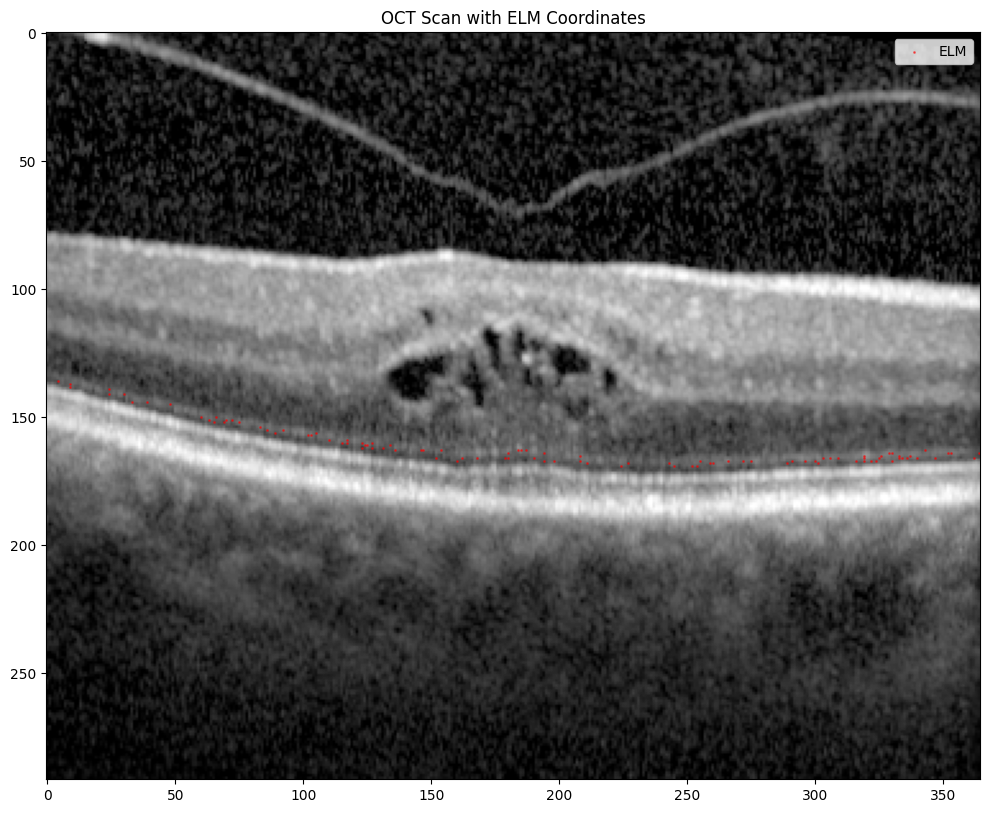

In [66]:
# Randomly select 100 rows
obs_rnd = segnet_elm[np.random.choice(segnet_elm.shape[0], size=100, replace=False), :]
obs_rnd = obs_rnd[obs_rnd[:, 0].argsort()]
utils.plot_elm(test_scan, obs_rnd)

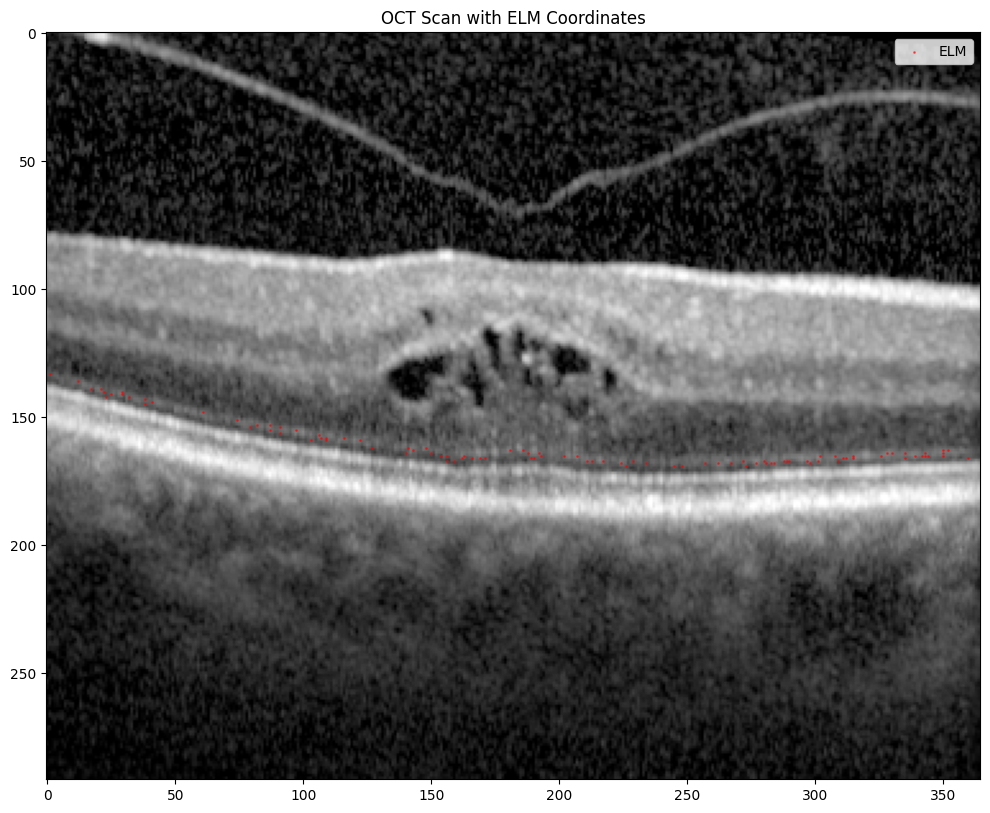

In [67]:
# Randomly select 100 rows again
obs_rnd2 = segnet_elm[np.random.choice(segnet_elm.shape[0], size=100, replace=False), :]
obs_rnd2 = obs_rnd2[obs_rnd2[:, 0].argsort()]
utils.plot_elm(test_scan, obs_rnd2)

In [68]:
obs_rnd[:, [0, 1]] = obs_rnd[:, [1, 0]]  # yx-plane to xy-plane
obs_rnd2[:, [0, 1]] = obs_rnd2[:, [1, 0]]  # yx-plane to xy-plane

In [69]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=obs_rnd
)

elm_tracer1 = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

In [70]:
p1, ci1 = elm_tracer1()

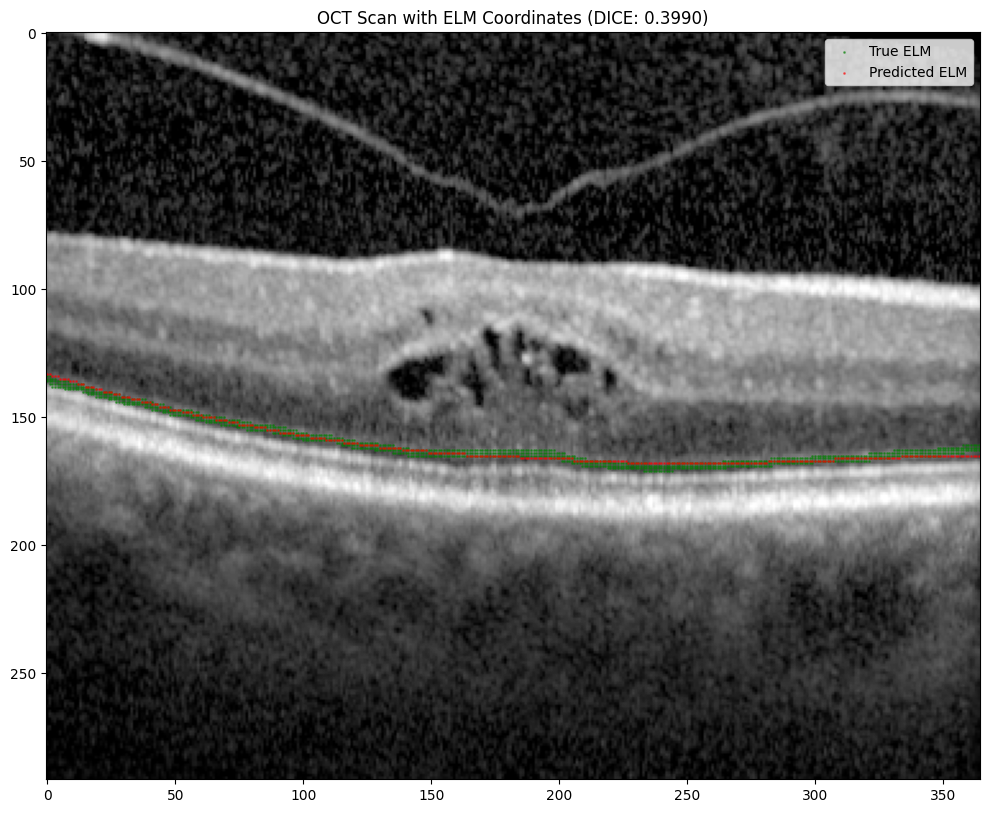

In [71]:
utils.plot_elm(test_scan, p1, compare=True, true_elm_coords=gt_elm)

In [72]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=obs_rnd2
)

elm_tracer2 = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

In [73]:
p2, ci2 = elm_tracer2()

In [74]:
p = np.vstack((p1, p2))
p = np.unique(p, axis=0)

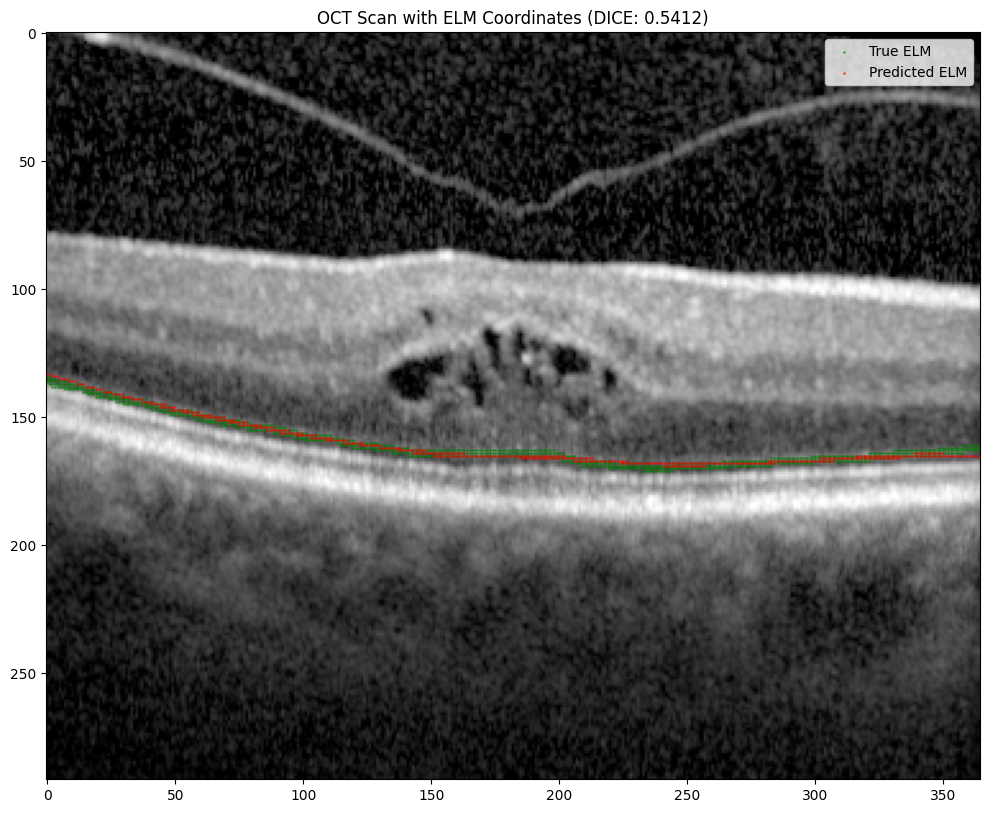

In [75]:
utils.plot_elm(test_scan, p, compare=True, true_elm_coords=gt_elm)

In [76]:
def dice(pred_coords, gt_coords, image_shape):
    """
    Calculate DICE coefficient for two sets of coordinates.

    Args:
    pred_coords (np.array): Predicted coordinates, shape (N, 2)
    gt_coords (np.array): Ground truth coordinates, shape (M, 2)
    image_shape (tuple): Shape of the original image (height, width)

    Returns:
    float: DICE coefficient
    """
    # Create binary masks from coordinates
    pred_mask = np.zeros(image_shape, dtype=bool)
    gt_mask = np.zeros(image_shape, dtype=bool)

    # Fill in the masks
    pred_mask[pred_coords[:, 0], pred_coords[:, 1]] = True
    gt_mask[gt_coords[:, 0], gt_coords[:, 1]] = True

    # Calculate intersection and union
    intersection = np.logical_and(pred_mask, gt_mask)

    # Calculate DICE coefficient
    dice = (2. * intersection.sum() + 1e-8) / (pred_mask.sum() + gt_mask.sum() + 1e-8)

    return dice

In [77]:
print(dice(p, gt_elm, test_scan.shape))
print(dice(segnet_elm, gt_elm, test_scan.shape))

0.5412462908039095
0.7559848803034188


In [78]:
segnet_elm

array([[133,   0],
       [134,   0],
       [136,   0],
       ...,
       [163, 364],
       [166, 364],
       [165, 364]])

In [79]:
import numpy as np


def create_subsets(segnet_elm, num_subsets=3, subset_size=100):
    # Sort the array by x-values (second column)
    sorted_indices = np.argsort(segnet_elm[:, 1])
    sorted_segnet_elm = segnet_elm[sorted_indices]

    # Get unique x-values and their indices
    unique_x, unique_indices = np.unique(sorted_segnet_elm[:, 1], return_index=True)

    # If we have fewer unique x-values than subset_size, we'll use all available
    if len(unique_x) < subset_size:
        subset_size = len(unique_x)

    # Randomly select subset_size unique x-values
    selected_x_indices = np.sort(np.random.choice(len(unique_x), size=subset_size, replace=False))
    selected_x = unique_x[selected_x_indices]

    # Create subsets
    subsets = []
    for _ in range(num_subsets):
        subset = []
        for x in selected_x:
            # Find all points with this x-value
            x_points = sorted_segnet_elm[sorted_segnet_elm[:, 1] == x]
            # Randomly select one point
            selected_point = x_points[np.random.randint(len(x_points))]
            subset.append(selected_point)

        subset = np.array(subset)
        subset[:, [0, 1]] = subset[:, [1, 0]]  # yx to xy
        subsets.append(subset)

    return subsets


subsets = create_subsets(segnet_elm, num_subsets=20)

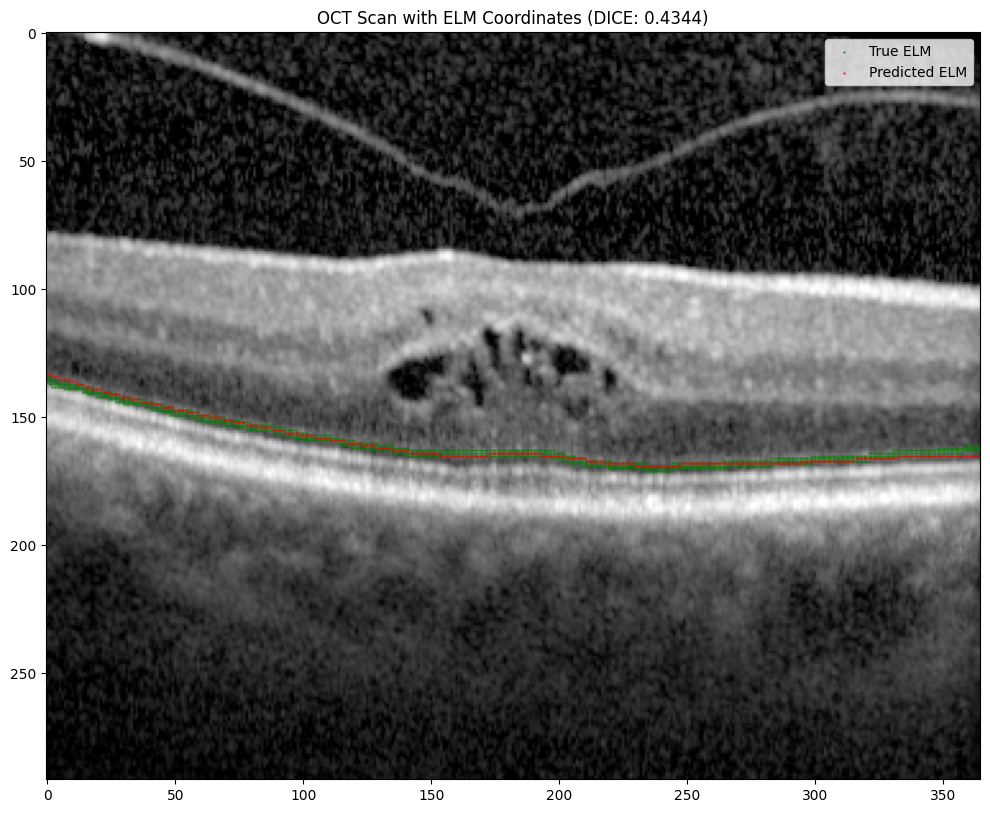

In [80]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=subsets[0]
)

elm_tracer = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

p, _ = elm_tracer()
utils.plot_elm(test_scan, p, compare=True, true_elm_coords=gt_elm)

In [81]:
def run_gpet_several(test_scan, test_edge_map, obs_list):
    preds = [None] * len(obs_list)  # Initialize the list with None placeholders
    for i, obs in enumerate(obs_list):
        gp_kwargs = dict(
            kernel_options={
                'kernel': 'RationalQuadratic',
                'sigma_f': 1.0,
                'length_scale': 1.0,
                'alpha': 2.0
            },
            delta_x=8,
            score_thresh=0.5,
            N_samples=1000,
            seed=1,
            noise_y=0.5,
            keep_ratio=0.1,
            pixel_thresh=5,
            fix_endpoints=True,
            return_std=True,
            obs=obs
        )

        elm_tracer = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)
        preds[i], _ = elm_tracer()

    pred_stack = np.vstack(preds)
    final_pred = np.unique(pred_stack, axis=0)

    return final_pred

In [82]:
fp = run_gpet_several(test_scan, test_edge_map, subsets)

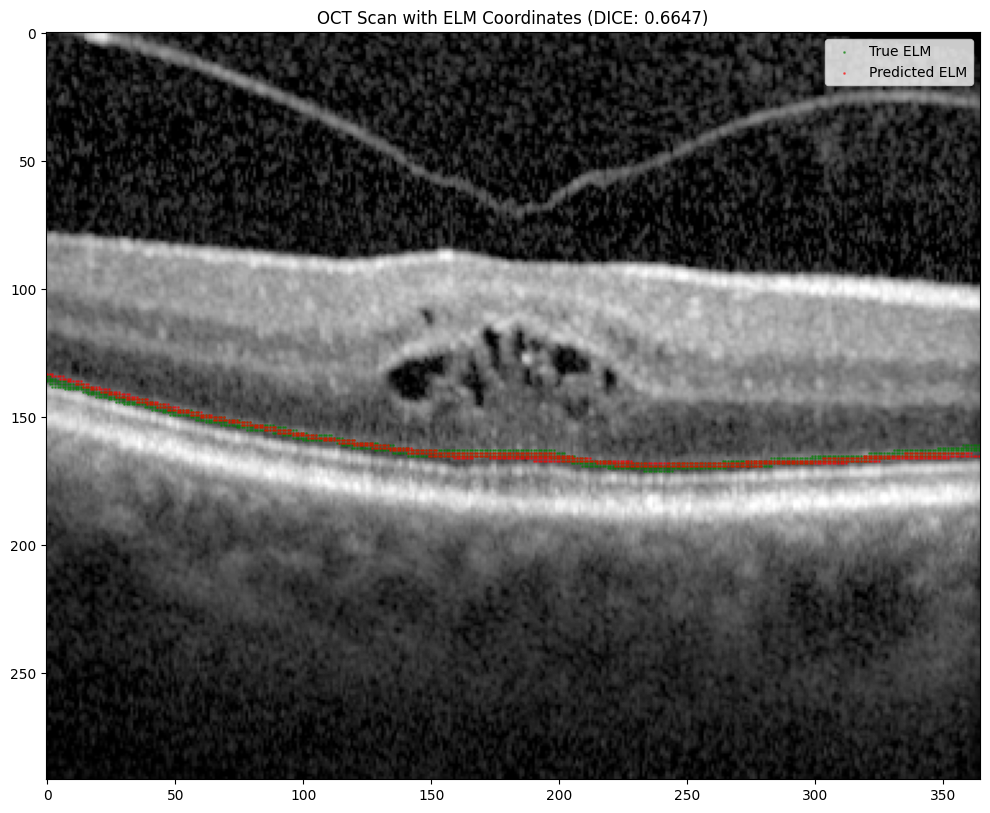

In [83]:
utils.plot_elm(test_scan, fp, compare=True, true_elm_coords=gt_elm)

In [84]:
print(dice(fp, gt_elm, test_scan.shape))
print(dice(segnet_elm, gt_elm, test_scan.shape))

0.6646556058337624
0.7559848803034188


## Solving the jump/Macular Hole(MH) issue in the GPEdgeTracer
I came up with a simple solution for this given that the SegNet is quite good at detecting the MHs. The new functions `find_jump_indices` and `remove_jump_ranges` are given a jump threshold and then the jump range is removed from the prediction from the GPEdgeTracer.  

In [85]:
def process_single_scan(test_idx, scans, pred_elm_coords, gt_elm_coords):
    # Load the test scan and corresponding ELM coordinates
    test_scan = scans[test_idx]
    segnet_elm = pred_elm_coords[test_idx]
    gt_elm = gt_elm_coords[test_idx]

    # Create a kernel for edge detection
    kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)

    # Compute the gradient image
    test_edge_map = utils.comp_grad_img(test_scan, kernel)

    # Get initialization edges from the pred_test aka mask
    init = segnet_elm[[0, -1], :][:, [1, 0]]

    # Create observations
    obs_sw = create_obs(segnet_elm, num_points=100)

    # Set up GPEdgeTracer parameters
    gp_kwargs = dict(
        kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
        delta_x=8,
        score_thresh=0.5,
        N_samples=1000,
        seed=1,
        noise_y=0.5,
        keep_ratio=0.1,
        pixel_thresh=5,
        fix_endpoints=True,
        return_std=True,
        obs=obs_sw
    )

    # Initialize and run GPEdgeTracer
    elm_tracer_sw = edgetrace.GPEdgeTracer(init, test_edge_map, **gp_kwargs)
    elm_pred_sw, elm_ci_sw = elm_tracer_sw()

    # Find and remove jump ranges
    jump_threshold = 10
    jump_indices, sorted_segnet_elm = find_jump_indices(segnet_elm, jump_threshold)
    elm_pred_sw_jump = remove_jump_ranges(elm_pred_sw, jump_indices, sorted_segnet_elm)

    # Plot results
    fig = utils.plot_elm(test_scan, elm_pred_sw_jump, compare=True, true_elm_coords=gt_elm)

    return elm_pred_sw_jump, fig


def create_obs(segnet_elm, num_points=100):
    sorted_elm = segnet_elm[segnet_elm[:, 1].argsort()]
    width = sorted_elm[:, 1].max() + 1
    window_size = width / (num_points // 2)
    obs = []
    for i in range(num_points // 2):
        x_start = int(i * window_size)
        x_end = int((i + 1) * window_size)
        window_points = sorted_elm[(sorted_elm[:, 1] >= x_start) & (sorted_elm[:, 1] < x_end)]
        if len(window_points) > 0:
            upper_point = window_points[np.argmin(window_points[:, 0])]
            obs.append(upper_point)
            lower_point = window_points[np.argmax(window_points[:, 0])]
            obs.append(lower_point)
    obs = np.array(obs)
    obs[:, [0, 1]] = obs[:, [1, 0]]
    return obs


def find_jump_indices(coords, jump_threshold):
    sorted_coords = coords[coords[:, 1].argsort()]
    x_diffs = np.diff(sorted_coords[:, 1])
    jump_indices = np.where(x_diffs > jump_threshold)[0]
    return jump_indices, sorted_coords


def remove_jump_ranges(coords, jump_indices, sorted_coords, buffer=1):
    mask = np.ones(coords.shape[0], dtype=bool)
    for idx in jump_indices:
        x_start = sorted_coords[idx, 1] - buffer
        x_end = sorted_coords[idx + 1, 1] + buffer
        mask &= ~((coords[:, 1] > x_start) & (coords[:, 1] < x_end))
    filtered_coords = coords[mask]
    return filtered_coords

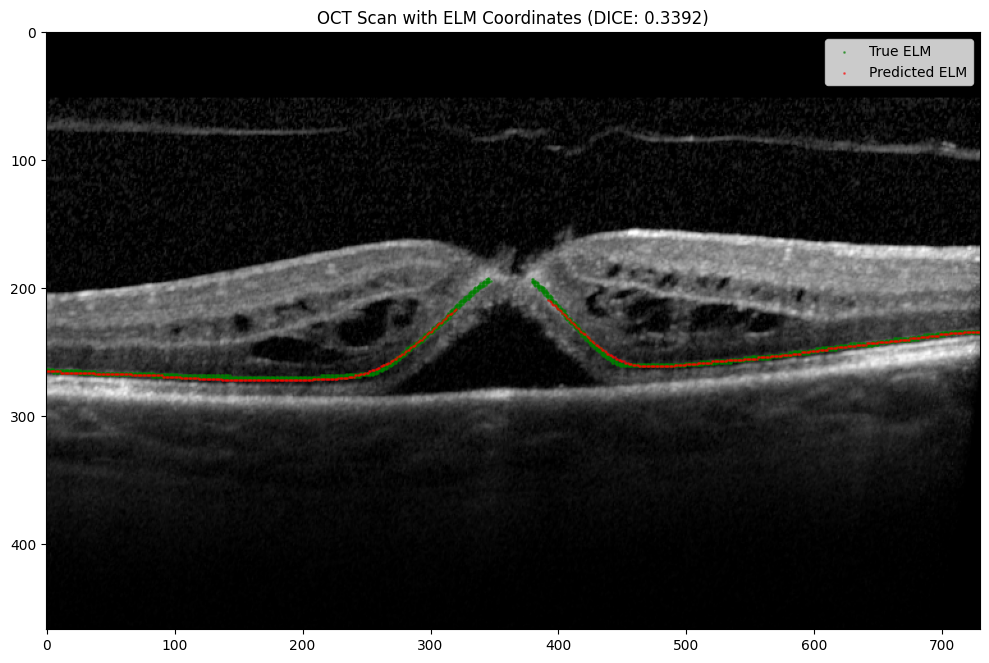

In [86]:
test_idx = 16
elm_pred_filtered, result_plot = process_single_scan(test_idx, scans, pred_elm_coords, gt_elm_coords)

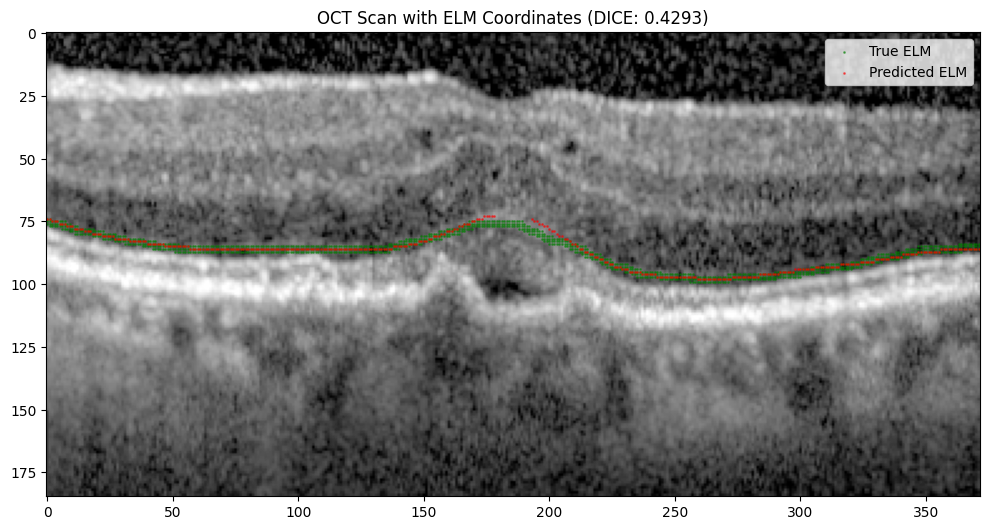

In [87]:
test_idx = 120
elm_pred_filtered, result_plot = process_single_scan(test_idx, scans, pred_elm_coords, gt_elm_coords)

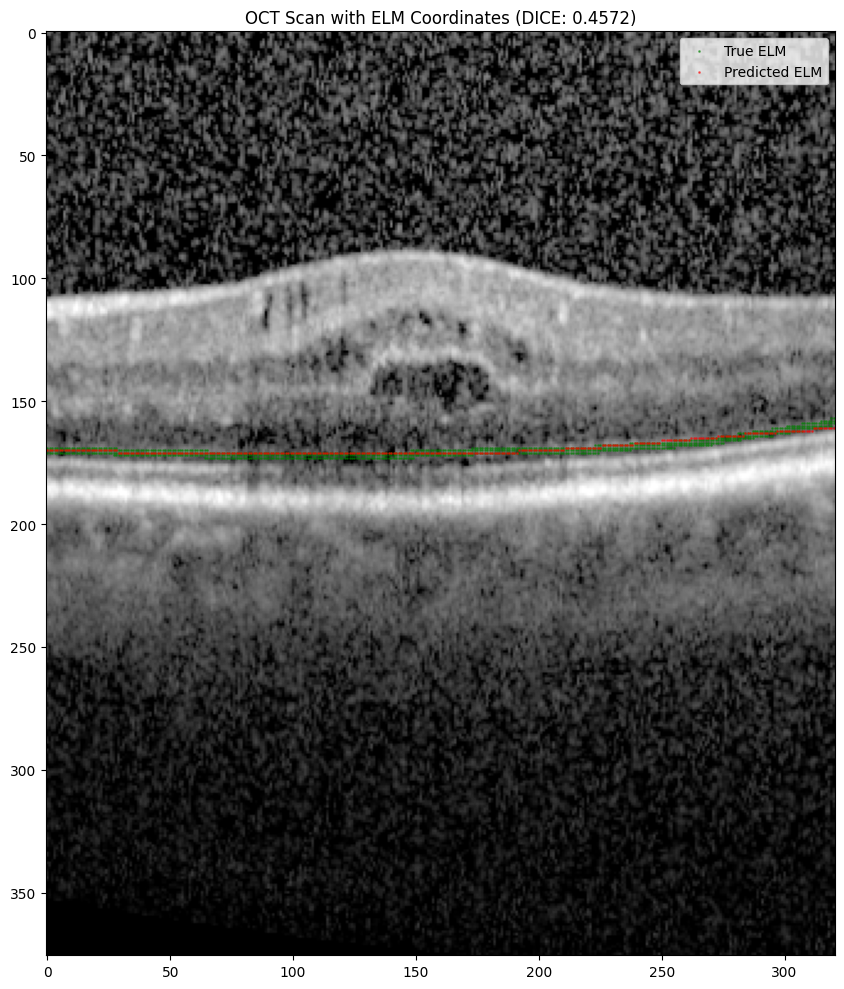

In [88]:
test_idx = 25
elm_pred_filtered, result_plot = process_single_scan(test_idx, scans, pred_elm_coords, gt_elm_coords)

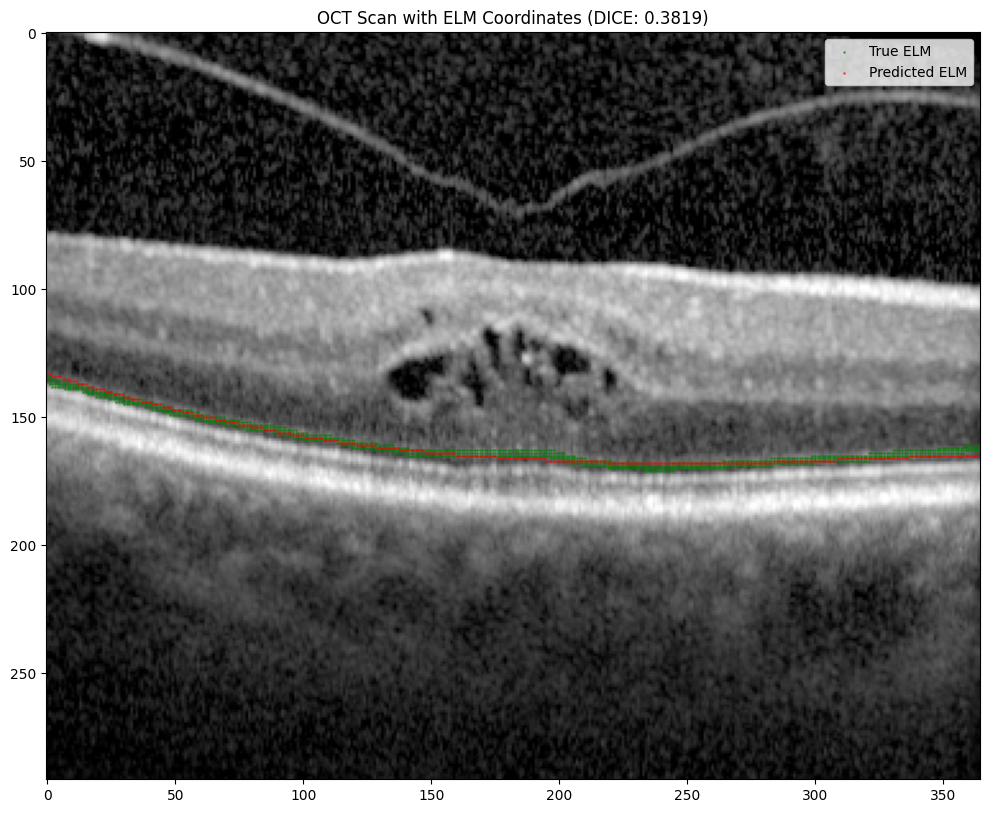

In [89]:
test_idx = 500
elm_pred_filtered, result_plot = process_single_scan(test_idx, scans, pred_elm_coords, gt_elm_coords)

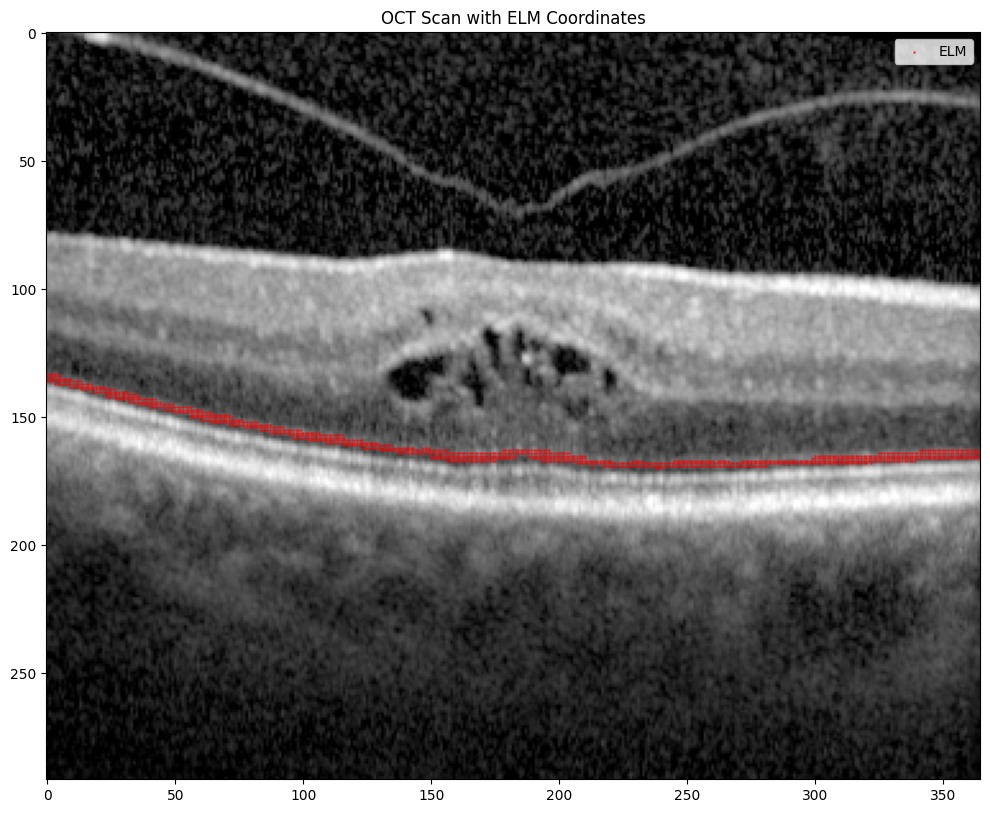

In [90]:
utils.plot_elm(test_scan, segnet_elm)